In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pickle
import estimator as e
import matplotlib.pyplot as plt

# Load data

In [34]:
with open("data/ecb.pkl" , "rb") as f:
    ecb = pickle.load(f)
    ecb.sort_index(inplace=True)
    
with open("data/fed.pkl" , "rb") as f:
    fed = pickle.load(f)
    fed.sort_index(inplace=True)

with open("data/macro_variables.pkl" , "rb") as f:
    data = pickle.load(f)
    data.sort_index(inplace=True)

#Romer-Romer monetary policy shocks
RR = pd.read_stata('data/RR_monetary_shock_monthly.dta')
RR.rename(columns={"date":"Date"}, inplace=True)
RR["Date"] = pd.to_datetime(RR["Date"])
RR.set_index("Date", inplace=True)

fed_surprise = fed[fed["Survey vs Actual"] != "Expected"].dropna()

## Non parametric estimator with "raw treatment"

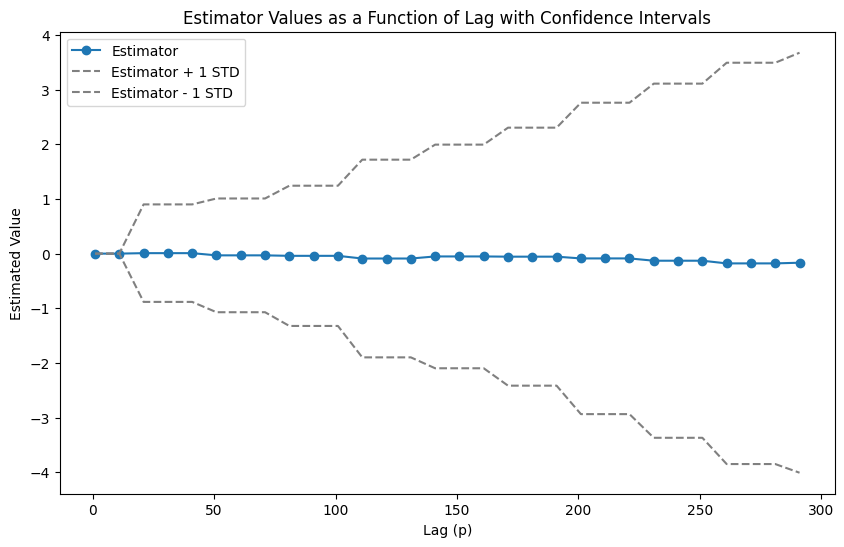

In [42]:
estimator= e.Estimator(W=RR, Y=data,treatment="resid_romer", outcome="USURTOT Index")
estimator.compute_estimator(p=10, h=0.03, w=0.1, w_prime=-0.1, min_obs=2)
estimator.plot_effect( h=0.03, w=0.1, w_prime=-0.1, p_range=[k for k in range(1,300,10)], min_obs=20)

## Local projection with "raw treatment"

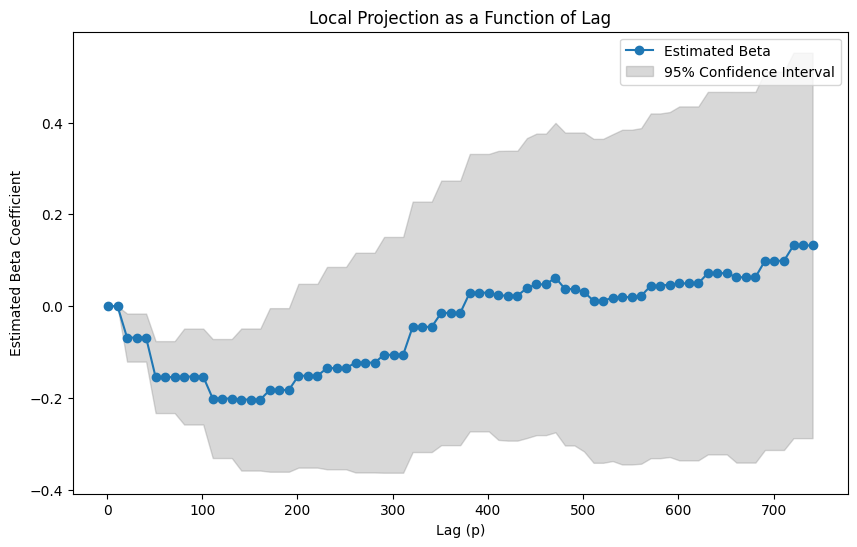

In [40]:
estimator.local_projection(p=200,min_obs=2, other_controls=None,lagW = [30], lagY=[0])
estimator.plot_local_projection(p_range=[k for k in range(1,750,10)],min_obs=2,lagW = [30], lagY=[0])

## Regression of the treatment

In [16]:
features={
    "USURTOT Index": [0], 
    "FEDFUNDS": [0],
    "CPICYOY Index" : [0]
}

reg, preds = estimator.regress_treatment(p=100, features = features)
residuals = preds["Actual_W"] - preds["Predicted_W"]

## Estimator using residualized treatment

In [ ]:
estimator= e.Estimator(W=fed, Y=data,treatment="Numeric Change", outcome="USURTOT Index")
estimator.compute_estimator( p=10, h=5, w=25, w_prime=-25, min_obs=2)
estimator.plot_effect( h=15, w=75, w_prime=0, p_range=[k for k in range(1,300,10)], min_obs=2)